In [3]:
!pip install numpy==1.23.3
!pip install scipy==1.8.1
!pip install scikit-learn==1.1.1

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: arcgis 2.0.1 has a non-standard dependency specifier keyring>=23.3.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of arcgis or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-pa

In [53]:
import sklearn
print("Scikit-learn version:", sklearn.__version__)

Scikit-learn version: 1.1.1


In [1]:
import os
import nbimporter
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import geopandas as gpd
from rasterio.features import rasterize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy


# Define paths
ROOT_DIR = '/home/jovyan/private/Research_thesis/Satellite_branch/'
IMAGE_FILE = os.path.join(ROOT_DIR, "Nrb_sentinel2_extent3857.tif")
LABEL_FILE = os.path.join(ROOT_DIR, "Nrb_reference_resampled_80m.tif")
VECTOR_FILE = os.path.join(ROOT_DIR, "Nrb_Bndry3857_new.shp")
MASK_FILE = os.path.join(ROOT_DIR, "Nrb_city_boundary_mask.tif")

# Constants
BANDS_COUNT = 4  # Number of bands: Red, Green, Blue
CLASSES_COUNT = 2  # Number of classes
PATCH_SIZE = 128
LABEL_PATCH_SIZE = 16   # Patch size for the label (80m resolution)
BATCH_SIZE = 16

# Class mapping
CLASS_MAPPING = {
    0: 0,  # non slum
    1: 1   # slum
}

Origin (latitude, longitude): (-129210.0, 4081450.0)


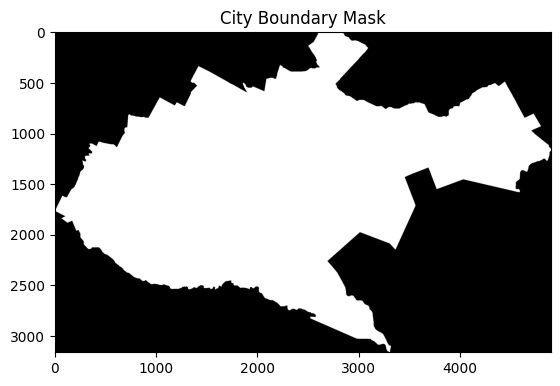

In [2]:
def read_mask(mask_path):
    with rasterio.open(mask_path) as mask_file:
        mask_array = mask_file.read(1)  # Read single band
    return mask_array

# 读取矢量文件
gdf = gpd.read_file(VECTOR_FILE)

# 读取栅格文件以获取变换信息和元数据
with rasterio.open(IMAGE_FILE) as src:
    transform = src.transform
    origin_lon, origin_lat = transform * (0, 0)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": src.height,
        "width": src.width,
        "transform": src.transform,
        "crs": src.crs,
        "count": 1,
        "dtype": 'uint8'
    })
    print(f"Origin (latitude, longitude): ({origin_lat}, {origin_lon})")

# 栅格化矢量边界
shapes = ((geom, 1) for geom in gdf.geometry)

with rasterio.open(MASK_FILE, 'w', **out_meta) as out_raster:
    out_raster.write(rasterize(shapes, out_shape=(src.height, src.width), transform=src.transform, fill=0, all_touched=True, dtype='uint8'), indexes=1)

# 检查栅格掩膜文件
mask = read_mask(MASK_FILE)
plt.imshow(mask, cmap='gray')
plt.title('City Boundary Mask')
plt.show()


def read_image(image_path, bands=[2, 3, 4, 8], normalize=False):
    with rasterio.open(image_path) as image_file:
        height, width = image_file.height, image_file.width
        image_array = np.empty((height, width, len(bands)))
        for i, band_idx in enumerate(bands):
            band_array = image_file.read(band_idx)
            if normalize:
                min_value = np.percentile(band_array, 2)
                max_value = np.percentile(band_array, 98)
                band_array = (band_array - min_value) / (max_value - min_value)
                band_array = np.clip(band_array, 0, 1)  # Ensure within 0-1 range
            image_array[:, :, i] = band_array
    return image_array


def map_classes(labels_array, mapping=CLASS_MAPPING):
    labels_mapped = np.zeros_like(labels_array)
    for class_idx, target_idx in mapping.items():
        labels_mapped[labels_array == class_idx] = target_idx
    return labels_mapped


def read_label(label_path):
    with rasterio.open(label_path) as label_file:
        label_array = label_file.read(1)  # Read single band
    label_array = np.where(label_array == -1, -1, label_array)  # Retain no_data value as -1
    label_array = map_classes(label_array).astype(int)  # Ensure labels are integers
    return label_array


def pad_to_patch_size(arr, patch_size=PATCH_SIZE, pad_value=0):
    height, width = arr.shape[:2]
    target_height = patch_size * int(np.ceil(height / patch_size))
    target_width = patch_size * int(np.ceil(width / patch_size))
    pad_height = target_height - height
    pad_width = target_width - width

    if arr.ndim == 3:
        depth = arr.shape[2]
        padded = np.full((target_height, target_width, depth), pad_value, dtype=arr.dtype)
    else:
        padded = np.full((target_height, target_width), pad_value, dtype=arr.dtype)

    padded[:height, :width] = arr
    return padded, (pad_height, pad_width)


def extract_patches(image, label, mask, patch_size=PATCH_SIZE, label_patch_size=LABEL_PATCH_SIZE):
    image, _ = pad_to_patch_size(image, patch_size, pad_value = 0)
    label, _ = pad_to_patch_size(label, label_patch_size, pad_value = 0)  # Adjust for 80m resolution
    mask, _ = pad_to_patch_size(mask, patch_size, pad_value = 0)

    img_patches = []
    lbl_patches = []
    mask_patches = []
    patch_coords = []
    patch_bounds = []

    height, width, _ = image.shape
    label_height, label_width = label.shape

    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            img_patch = image[i:i+patch_size, j:j+patch_size, :]
            lbl_patch = label[(i//8):(i//8)+label_patch_size, (j//8):(j//8)+label_patch_size]  # Adjust for 80m resolution
            mask_patch = mask[i:i+patch_size, j:j+patch_size]

            img_patches.append(img_patch)
            lbl_patches.append(lbl_patch)
            mask_patches.append(mask_patch)
            patch_coords.append((i // patch_size, j // patch_size))

            if transform:
                # 计算patch边界坐标
                top_left = transform * (j, i)
                top_right = transform * (j + patch_size, i)
                bottom_left = transform * (j, i + patch_size)
                bottom_right = transform * (j + patch_size, i + patch_size)
                patch_bounds.append([top_left, top_right, bottom_right, bottom_left])

    return np.array(img_patches), np.array(lbl_patches), np.array(mask_patches), patch_coords, patch_bounds


def ensure_all_classes_present(labels, num_classes=CLASSES_COUNT):
    unique_classes = set()
    for lbl_patch in labels:
        unique_classes.update(np.unique(lbl_patch))
    return len(unique_classes) == num_classes


def labels_to_onehot(labels_arr, num_classes=CLASSES_COUNT):
    height, width = labels_arr.shape
    labels_onehot = np.zeros((height, width, num_classes))
    for class_idx in range(num_classes):
        labels_onehot[:, :, class_idx][labels_arr == class_idx] = 1
    return labels_onehot


def split_patches(img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds, train_size=0.6, val_size=0.2, test_size=0.2):
    inside_patches = [(img, lbl, mask, coord, bound) for img, lbl, mask, coord, bound in zip(img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds) if np.any(mask != 0)]
    outside_patches = [(img, lbl, mask, coord, bound) for img, lbl, mask, coord, bound in zip(img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds) if np.all(mask == 0)]

    if inside_patches:
        inside_img_patches, inside_lbl_patches, inside_mask_patches, inside_patch_coords, inside_patch_bounds = zip(*inside_patches)
    else:
        inside_img_patches, inside_lbl_patches, inside_mask_patches, inside_patch_coords, inside_patch_bounds = [], [], [], [], []

    if outside_patches:
        outside_img_patches, outside_lbl_patches, outside_mask_patches, outside_patch_coords, outside_patch_bounds = zip(*outside_patches)
    else:
        outside_img_patches, outside_lbl_patches, outside_mask_patches, outside_patch_coords, outside_patch_bounds = [], [], [], [], []

    inside_img_patches = np.array(inside_img_patches)
    inside_lbl_patches = np.array(inside_lbl_patches)
    inside_mask_patches = np.array(inside_mask_patches)
    inside_patch_coords = np.array(inside_patch_coords)
    inside_patch_bounds = np.array(inside_patch_bounds)

    # Flatten labels and include all values
    flat_labels = [lbl.flatten() for lbl in inside_lbl_patches]
    flat_labels = [label[0] if len(label) > 0 else 0 for label in flat_labels]  # Handle empty labels

    # Perform initial split with stratification
    X_train, X_temp, y_train, y_temp, mask_train, mask_temp, train_coords, temp_coords, train_bounds, temp_bounds = train_test_split(
        inside_img_patches, inside_lbl_patches, inside_mask_patches, inside_patch_coords, inside_patch_bounds, test_size=(1 - train_size), random_state=42, stratify=flat_labels)

    flat_temp_labels = [lbl.flatten() for lbl in y_temp]
    flat_temp_labels = [label[0] if len(label) > 0 else 0 for label in flat_temp_labels]  # Handle empty labels

    X_val, X_test, y_val, y_test, mask_val, mask_test, val_coords, test_coords, val_bounds, test_bounds = train_test_split(
        X_temp, y_temp, mask_temp, temp_coords, temp_bounds, test_size=test_size / (val_size + test_size), random_state=42, stratify=flat_temp_labels)

    while not (ensure_all_classes_present(y_train, num_classes=2) and ensure_all_classes_present(y_val, num_classes=2) and ensure_all_classes_present(y_test, num_classes=2)):
        X_train, X_temp, y_train, y_temp, mask_train, mask_temp, train_coords, temp_coords, train_bounds, temp_bounds = train_test_split(
            np.concatenate((X_train, X_temp)), np.concatenate((y_train, y_temp)), np.concatenate((mask_train, mask_temp)),
            np.concatenate((train_coords, temp_coords)), np.concatenate((train_bounds, temp_bounds)), test_size=(1 - train_size), random_state=42)
        
        flat_temp_labels = [lbl.flatten() for lbl in y_temp]
        flat_temp_labels = [label[0] if len(label) > 0 else 0 for label in flat_temp_labels]  # Handle empty labels

        X_val, X_test, y_val, y_test, mask_val, mask_test, val_coords, test_coords, val_bounds, test_bounds = train_test_split(
            X_temp, y_temp, mask_temp, temp_coords, temp_bounds, test_size=test_size / (val_size + test_size), random_state=42, stratify=flat_temp_labels)

    outside_img_patches = np.array(outside_img_patches, dtype=object)
    outside_lbl_patches = np.array(outside_lbl_patches, dtype=object)
    outside_mask_patches = np.array(outside_mask_patches, dtype=object)
    outside_patch_coords = np.array(outside_patch_coords, dtype=object)

    return X_train, X_val, X_test, outside_img_patches, y_train, y_val, y_test, outside_lbl_patches, mask_train, mask_val, mask_test, outside_mask_patches, train_coords, val_coords, test_coords, train_bounds, val_bounds, test_bounds, outside_patch_coords

In [3]:
# Read data
image = read_image(IMAGE_FILE, normalize=True)
label = read_label(LABEL_FILE)
mask = read_mask(MASK_FILE)  # 读取城市边界掩膜

# Check image, label, and mask sizes
print(f'Image size: {image.shape}')
print(f'Label size: {label.shape}')
print(f'Mask size: {mask.shape}')

# Extract patches
img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds = extract_patches(image, label, mask)

# Split patches
X_train, X_val, X_test, X_out, y_train, y_val, y_test, y_out, mask_train, mask_val, mask_test, mask_out, train_coords, val_coords, test_coords, train_bounds, val_bounds, test_bounds, out_coords = split_patches(
    img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds)

# Print the number of patches in each dataset
print(f'Total patches: {len(img_patches)}')
print(f'Training patches: {len(X_train)}')
print(f'Validation patches: {len(X_val)}')
print(f'Test patches: {len(X_test)}')
print(f'Out patches: {len(X_out)}')

Image size: (3160, 4897, 4)
Label size: (394, 611)
Mask size: (3160, 4897)
Total patches: 975
Training patches: 306
Validation patches: 102
Test patches: 102
Out patches: 465


In [4]:
import pandas as pd
from pyproj import Transformer

REFERENCE_MAP_PATH = LABEL_FILE
GSV_path = '/home/jovyan/private/Research_thesis/Streetview_branch/Nrb_GSV/Nrb_images/Nrb_images/'

# 读取参考地图
with rasterio.open(REFERENCE_MAP_PATH) as src:
    reference_map = src.read(1)
    reference_transform = src.transform

# 定义坐标转换器
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# 将经纬度转换为参考地图的坐标系
def lonlat_to_pixel(lon, lat, transform, transformer):
    x, y = transformer.transform(lon, lat)
    col, row = ~transform * (x, y)
    return int(col), int(row)

In [5]:
# 解析图像文件名并获取经纬度
def parse_filename(filename):
    parts = filename[:-4].split('_')
    if len(parts) == 3:
        fid = parts[0]
        lon = float(parts[1])
        lat = float(parts[2])
        return fid, lon, lat
    else:
        raise ValueError(f"Filename {filename} does not match expected pattern.")

# 测试解析函数
filename = "12345_36.8219_-1.2921.jpg"
try:
    fid, lon, lat = parse_filename(filename)
    print(f"FID: {fid}, Longitude: {lon}, Latitude: {lat}")
except ValueError as e:
    print(e)

# 读取图像文件名并提取经纬度
image_files = [f for f in os.listdir(GSV_path) if f.endswith('.jpg')]
image_data = []

for image_file in image_files:
    fid, lon, lat = parse_filename(image_file)
    image_data.append((image_file, fid, lon, lat))

# 将数据转换为DataFrame
image_df = pd.DataFrame(image_data, columns=['filename', 'fid', 'longitude', 'latitude'])

FID: 12345, Longitude: 36.8219, Latitude: -1.2921


In [6]:
# 根据参考地图分类图像
def classify_image(lon, lat, reference_map, transform, transformer):
    col, row = lonlat_to_pixel(lon, lat, transform, transformer)
    if 0 <= row < reference_map.shape[0] and 0 <= col < reference_map.shape[1]:
        value = reference_map[row, col]
        if value == 0:
            return 'non slum'
        elif value == 1:
            return 'slum'
    return 'out'

image_df['category'] = image_df.apply(lambda x: classify_image(x['longitude'], x['latitude'], reference_map, reference_transform, transformer), axis=1)

# 输出每个label的街景图像数量
label_counts = image_df['category'].value_counts()
print("Street view image counts per category:")
print(label_counts)

Street view image counts per category:
non slum    28147
slum         5897
Name: category, dtype: int64


In [7]:
from shapely.geometry import Point, Polygon
from pyproj import Transformer

# 初始化转换器
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

def classify_image_by_region(lon, lat, train_bounds, val_bounds, test_bounds, transformer):
    
    x, y = transformer.transform(lat, lon)
    point = Point(x, y)
    
    for bounds in train_bounds:
        polygon = Polygon(bounds)
        if polygon.contains(point):
            return 'train'
    for bounds in val_bounds:
        polygon = Polygon(bounds)
        if polygon.contains(point):
            return 'val'
    for bounds in test_bounds:
        polygon = Polygon(bounds)
        if polygon.contains(point):
            return 'test'
    return None


# 将边界转换为Polygon对象
train_polygons = [Polygon(bounds) for bounds in train_bounds]
val_polygons = [Polygon(bounds) for bounds in val_bounds]
test_polygons = [Polygon(bounds) for bounds in test_bounds]


train_images = []
val_images = []
test_images = []

for _, row in image_df.iterrows():
    lon, lat = row['longitude'], row['latitude']
    label = row['category']
    region = classify_image_by_region(lon, lat, train_bounds, val_bounds, test_bounds, transformer)
    if region == 'train':
        train_images.append((row['filename'], label))
    elif region == 'val':
        val_images.append((row['filename'], label))
    elif region == 'test':
        test_images.append((row['filename'], label))


# 输出数据集大小
print(f"Train set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

# 验证总数
total_images = len(train_images) + len(val_images) + len(test_images)
print(f"Total images: {total_images}")

Train set: 20192 images
Validation set: 6231 images
Test set: 7621 images
Total images: 34044


In [11]:
# import numpy as np
# import rasterio
# from rasterio.enums import Resampling
# from rasterio.transform import from_bounds
# from rasterio.warp import reproject


# # Resample function with rasterio
# def resample_with_rasterio(src_array, scale=0.125, resampling_method=Resampling.nearest):
#     height, width = src_array.shape
#     new_height, new_width = int(height * scale), int(width * scale)

#     src_transform = from_bounds(0, 0, width, height, width, height)
#     dst_transform = from_bounds(0, 0, new_width, new_height, new_width, new_height)

#     resampled_array = np.zeros((new_height, new_width), dtype=src_array.dtype)
#     with rasterio.Env():
#         reproject(
#             src_array,
#             resampled_array,
#             src_transform=src_transform,
#             dst_transform=dst_transform,
#             src_crs='EPSG:3857',
#             dst_crs='EPSG:3857',
#             resampling=resampling_method
#         )

#     return resampled_array


# # Resample the label patches
# y_train_resampled = np.array([resample_with_rasterio(patch) for patch in y_train])
# y_val_resampled = np.array([resample_with_rasterio(patch) for patch in y_val])
# y_test_resampled = np.array([resample_with_rasterio(patch) for patch in y_test])

# # Print shapes of the resampled patches to ensure correctness
# print(f'Resampled training patches shape: {y_train_resampled.shape}')
# print(f'Resampled validation patches shape: {y_val_resampled.shape}')
# print(f'Resampled test patches shape: {y_test_resampled.shape}')

# # Validate by printing some sample data
# for i in range(min(len(y_train), 5)):  # Print first 5 patches for validation
#     print(f"Original train array sample data {i}:\n{y_train[i][:5, :5]}")
#     print(f"Resampled train array sample data {i}:\n{y_train_resampled[i][:5, :5]}")
# for i in range(min(len(y_val), 5)):  # Print first 5 patches for validation
#     print(f"Original val array sample data {i}:\n{y_val[i][:5, :5]}")
#     print(f"Resampled val array sample data {i}:\n{y_val_resampled[i][:5, :5]}")
# for i in range(min(len(y_test), 5)):  # Print first 5 patches for validation
#     print(f"Original test array sample data {i}:\n{y_test[i][:5, :5]}")
#     print(f"Resampled test array sample data {i}:\n{y_test_resampled[i][:5, :5]}")

In [7]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, ReLU, Input
from tensorflow.keras.models import Model


def build_unet_encoder(input_shape=(128, 128, 4)):
    inputs = layers.Input(input_shape)

    # Block 1
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Output size: (64, 64, 64)

    # Block 2
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # Output size: (32, 32, 128)

    # Block 3
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # Output size: (16, 16, 256)

#     # Block 4
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#     # Output size: (8, 8, 512)

#     # Upsampling Block 1
#     up1 = layers.UpSampling2D(size=(2, 2))(pool4)
#     up1 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
#     up1 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
#     # Output size: (16, 16, 256)

    # # 添加1x1卷积层将维度减少到256
    # conv6 = Conv2D(256, (1, 1), activation='relu', padding='same')(conv5)

    model = Model(inputs=inputs, outputs=pool3)
    return model


def build_resnet50_model(input_shape=(128, 500, 3)):
    # 加载预训练的ResNet50模型，不包括顶部的全连接层
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # output shape: 1x1x2048
    x = Dense(256, activation='relu')(x)  # output shape: 1x256
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [8]:
import numpy as np
from shapely.geometry import Point, Polygon
from pyproj import Transformer


def generate_pixel_bounds(patch_bounds, grid_size):
    """
    生成每个patch的pixel边界列表。
    
    参数:
    patch_bounds (list): patch的边界列表，每个元素是一个包含4个点的列表，表示patch的四个顶点。
    grid_size (int): 每个patch的网格大小，例如8x8。
    
    返回:
    list: 每个patch的pixel边界列表，每个元素是一个包含4个点的列表，表示pixel的四个顶点。
    """

    pixel_bounds_list = []
    for bounds in patch_bounds:
        top_left, top_right, bottom_right, bottom_left = bounds
        width = (top_right[0] - top_left[0]) / grid_size
        height = (bottom_left[1] - top_left[1]) / grid_size
        for i in range(grid_size):
            for j in range(grid_size):
                pixel_top_left = (top_left[0] + j * width, top_left[1] + i * height)
                pixel_top_right = (top_left[0] + (j + 1) * width, top_left[1] + i * height)
                pixel_bottom_left = (top_left[0] + j * width, top_left[1] + (i + 1) * height)
                pixel_bottom_right = (top_left[0] + (j + 1) * width, top_left[1] + (i + 1) * height)
                pixel_bounds_list.append([pixel_top_left, pixel_top_right, pixel_bottom_right, pixel_bottom_left])
    return pixel_bounds_list


def find_max_gsv_features_per_pixel(gsv_image_paths, patch_bounds_list, transformer):
    max_gsv_features = 0
    for bounds in patch_bounds_list:
        # 假设使用第一个图像来获取grid_size
        rs_image = unet_model.predict(np.expand_dims(np.zeros((128, 128, 4)), axis=0))[0]
        grid_size = rs_image.shape[0]  # 动态获取grid_size
        pixel_bounds_list = generate_pixel_bounds([bounds], grid_size=grid_size)
        for pixel_bounds in pixel_bounds_list:
            num_features = 0
            for gsv_path in gsv_image_paths:
                fid, lon, lat = parse_filename(os.path.basename(gsv_path))
                x, y = transformer.transform(lat, lon)
                point = Point(x, y)
                if point.within(Polygon(pixel_bounds)):
                    num_features += 1
            if num_features > max_gsv_features:
                max_gsv_features = num_features
            print(f"Pixel bounds: {pixel_bounds}, GSV features count: {num_features}")  # Debug output
    return max_gsv_features


def pad_features(features, max_features, feature_dim):
    """
    将特征填充到最大特征数量。
    
    参数:
    features (numpy.ndarray): 特征数组，形状为 (num_features, feature_dim)
    max_features (int): 最大特征数量
    feature_dim (int): 每个特征的维度
    
    返回:
    numpy.ndarray: 填充后的特征数组，形状为 (max_features, feature_dim)
    """
    padded_features = np.zeros((max_features, feature_dim))
    features_to_add = min(len(features), max_features)
    features_array = np.array(features)  # 将列表转换为NumPy数组
    for i in range(features_to_add):
        padded_features[i, :] = features_array[i]
    return padded_features


def feature_fusion(unet_feature, gsv_features, max_gsv_features):
    """
    将遥感特征和谷歌街景特征进行拼接。
    
    参数:
    unet_feature (numpy.ndarray): 单个遥感特征，形状为 (256,)
    gsv_features (list of numpy.ndarray): 谷歌街景特征列表，每个特征形状为 (256,)
    max_gsv_features (int): 最大谷歌街景特征数量
    
    返回:
    numpy.ndarray: 拼接后的特征向量，形状为 (256 + 256*max_gsv_features,)
    """
    # 遥感特征：1x256
    unet_feature_flat = unet_feature.flatten()
    
    # 对齐谷歌街景特征，不足max_gsv_features的用0填充
    gsv_features_padded = pad_features(gsv_features, max_gsv_features, 256)
    
    # 展平谷歌街景特征：max_gsv_features x 256 -> 256 * max_gsv_features
    gsv_features_flat = gsv_features_padded.flatten()
    
    # 拼接特征
    fused_features = np.concatenate((unet_feature_flat, gsv_features_flat))
    
    return fused_features

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence


def load_image(path, target_size):
    image = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    return image / 255.0


def get_gsv_images_within_bounds(pixel_bounds, gsv_image_paths, transformer):
    gsv_images = []
    pixel_polygon = Polygon(pixel_bounds)
    for gsv_path in gsv_image_paths:
        try:
            fid, lon, lat = parse_filename(os.path.basename(gsv_path))
            x, y = transformer.transform(lat, lon)
            point = Point(x, y)
            if point.within(pixel_polygon):
                img = load_image(gsv_path, target_size=(128, 500))
                gsv_images.append(img)
        except ValueError as e:
            print(f"Error parsing filename {gsv_path}: {e}")
    return gsv_images


def generate_fused_features(rs_images, patch_bounds, labels, gsv_image_paths, transformer, unet_model, resnet_model, max_gsv_features):
    all_fused_features = []
    all_labels = []
    all_batch_gsv_features = 0
    all_batch_rs_features = 0

    for rs_image, patch_bound, label in zip(rs_images, patch_bounds, labels):
        rs_feature_map = unet_model.predict(np.expand_dims(rs_image, axis=0))[0]
        grid_size = rs_feature_map.shape[0]
        pixel_bounds_list = generate_pixel_bounds([patch_bound], grid_size=grid_size)
        # all_batch_rs_features += rs_feature_map.shape[0] * rs_feature_map.shape[1]

        for pixel_bounds in pixel_bounds_list:
            gsv_images = get_gsv_images_within_bounds(pixel_bounds, gsv_image_paths, transformer)
            gsv_features_list = [resnet_model.predict(np.expand_dims(img, axis=0))[0] for img in gsv_images]
            all_batch_gsv_features += len(gsv_features_list)
            x, y = divmod(pixel_bounds_list.index(pixel_bounds), grid_size)
            rs_feature = rs_feature_map[x, y, :]
            fused_feature = feature_fusion(rs_feature, gsv_features_list, max_gsv_features)
            all_fused_features.append(fused_feature)
            pixel_label = label[x, y]
            all_labels.append(pixel_label)
            all_batch_rs_features += 1

    fused_features = np.array(all_fused_features)
    labels_array = np.array(all_labels)
    print(f"Total number of labels: {labels_array.shape[0]}")
    print(f"Final fused features shape: {fused_features.shape}")
    return fused_features, labels_array, all_batch_gsv_features, all_batch_rs_features

# def generate_fused_features(rs_images, patch_bounds, labels, gsv_image_paths, transformer, unet_model, resnet_model, max_gsv_features):
#     all_fused_features = []
#     all_labels = []
#     all_batch_gsv_features = 0
#     all_batch_rs_features = 0

#     for rs_image, patch_bound, label in zip(rs_images, patch_bounds, labels):
#         rs_feature_map = unet_model.predict(np.expand_dims(rs_image, axis=0))[0]
#         grid_size = rs_feature_map.shape[0]
#         pixel_bounds_list = generate_pixel_bounds([patch_bound], grid_size=grid_size)
        
#         print(f"Processing patch: {patch_bound}")
#         print(f"Grid size: {grid_size}")

#         for pixel_bounds in pixel_bounds_list:
#             gsv_images = get_gsv_images_within_bounds(pixel_bounds, gsv_image_paths, transformer)
#             gsv_features_list = [resnet_model.predict(np.expand_dims(img, axis=0))[0] for img in gsv_images]
#             all_batch_gsv_features += len(gsv_features_list)
#             x, y = divmod(pixel_bounds_list.index(pixel_bounds), grid_size)
#             rs_feature = rs_feature_map[x, y, :]
#             fused_feature = feature_fusion(rs_feature, gsv_features_list, max_gsv_features)
#             all_fused_features.append(fused_feature)
#             pixel_label = label[x, y]
#             all_labels.append(pixel_label)
#             all_batch_rs_features += 1

#             print(f"Pixel bounds: {pixel_bounds}, GSV images: {len(gsv_images)}")

#     fused_features = np.array(all_fused_features)
#     labels_array = np.array(all_labels)
#     print(f"Total number of labels: {labels_array.shape[0]}")
#     print(f"Final fused features shape: {fused_features.shape}")
#     return fused_features, labels_array, all_batch_gsv_features, all_batch_rs_features


# class DataGenerator(Sequence):
#     def __init__(self, rs_images, rs_labels, patch_bounds, gsv_image_paths, max_gsv_features, transformer, batch_size=16, shuffle=True):
#         self.rs_images = rs_images
#         self.rs_labels = rs_labels
#         self.patch_bounds = patch_bounds
#         self.gsv_image_paths = gsv_image_paths
#         self.max_gsv_features = max_gsv_features
#         self.transformer = transformer
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end(
#         self.total_gsv_features = 0
#         self.total_rs_features = 0
#         # self.total_gsv_features = len(gsv_image_paths)
#         # self.total_rs_features = len(rs_images) * 8 * 8

#     def __len__(self):
#         return int(np.floor(len(self.rs_images) / self.batch_size))

#     def __getitem__(self, index):
#         indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         rs_images_batch = [self.rs_images[i] for i in indices]
#         rs_labels_batch = [self.rs_labels[i] for i in indices]
#         patch_bounds_batch = [self.patch_bounds[i] for i in indices]
#         fused_features, labels, batch_gsv_features, batch_rs_features = self.__data_generation(rs_images_batch, patch_bounds_batch, rs_labels_batch)
#         self.total_gsv_features += batch_gsv_features
#         self.total_rs_features += batch_rs_features
#         return fused_features, labels

#     def on_epoch_end(self):
#         self.indices = np.arange(len(self.rs_images))
#         if self.shuffle:
#             np.random.shuffle(self.indices)

#     def load_image(self, path, target_size):
#         image = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
#         image = tf.keras.preprocessing.image.img_to_array(image)
#         return image / 255.0  # Normalize to [0, 1]

#     def get_gsv_images_within_bounds(self, pixel_bounds):
#         gsv_images = []
#         pixel_polygon = Polygon(pixel_bounds)
#         for gsv_path in self.gsv_image_paths:
#             try:
#                 fid, lon, lat = parse_filename(os.path.basename(gsv_path))
#                 x, y = self.transformer.transform(lat, lon)  # 修正坐标转换顺序
#                 point = Point(x, y)
#                 if point.within(pixel_polygon):
#                     img = self.load_image(gsv_path, target_size=(128, 500))
#                     gsv_images.append(img)
#             except ValueError as e:
#                 print(f"Error parsing filename {gsv_path}: {e}")
#         return gsv_images

#     def __data_generation(self, rs_images_batch, patch_bounds_batch, labels_batch):
#         fused_feature_list = []
#         batch_gsv_features = 0
#         batch_rs_features = 0
#         grid_size = None

#         for rs_image, patch_bound in zip(rs_images_batch, patch_bounds_batch):
#             rs_feature_map = unet_model.predict(np.expand_dims(rs_image, axis=0))[0]
#             if grid_size is None:
#                 grid_size = rs_feature_map.shape[0]
#             batch_rs_features += rs_feature_map.shape[0] * rs_feature_map.shape[1]
#             pixel_bounds_list = generate_pixel_bounds([patch_bound], grid_size=grid_size)
#             for pixel_bounds in pixel_bounds_list:
#                 gsv_images = self.get_gsv_images_within_bounds(pixel_bounds)
#                 gsv_features_list = [resnet_model.predict(np.expand_dims(img, axis=0))[0] for img in gsv_images]
#                 batch_gsv_features += len(gsv_features_list)
#                 x, y = divmod(pixel_bounds_list.index(pixel_bounds), 8)
#                 rs_feature = rs_feature_map[x, y, :]
#                 fused_feature = feature_fusion(rs_feature, gsv_features_list, self.max_gsv_features)
#                 fused_feature_list.append((x, y, fused_feature))
#         # fused_features = np.zeros((8, 8, 256 + 256 * self.max_gsv_features))
#         # Determine the shape of the fused features dynamically
#         fused_feature_shape = (len(rs_images_batch), grid_size, grid_size, fused_feature_list[0][2].shape[0])
#         fused_features = np.zeros(fused_feature_shape)
#         for x, y, fused_feature in fused_feature_list:
#             fused_features[0, x, y, :] = fused_feature  # Corrected index
#         print(f"Final fused features shape: {fused_features.shape}")
#         labels = np.array(labels_batch)
#         return fused_features, labels, batch_gsv_features, batch_rs_features

In [10]:
# 创建输出文件夹
output_base_path = '/home/jovyan/private/Research_thesis/Streetview_branch/Nrb_GSV/cropped_images_labelled_80m/'

# 定义特征提取模型
unet_model = build_unet_encoder(input_shape=(128, 128, 4))
resnet_model = build_resnet50_model(input_shape=(128, 500, 3))

2024-08-14 13:34:23.791021: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [11]:
# Create a dummy input image
dummy_image = np.zeros((128, 128, 4))

# Predict using the model to get the feature map
feature_map = unet_model.predict(np.expand_dims(dummy_image, axis=0))[0]

# Get grid size from the feature map
grid_size = feature_map.shape[0]

# Calculate pixel size (assuming original pixel size is 10m for Sentinel-2)
original_pixel_size = 10  # meters
scaled_pixel_size = original_pixel_size * (128 / grid_size)

print(f"Grid size: {grid_size}")
print(f"Original pixel size: {original_pixel_size} meters")
print(f"Pixel size in feature map: {scaled_pixel_size} meters")

1/1 [==============================] - 4s 4s/step
Grid size: 16
Original pixel size: 10 meters
Pixel size in feature map: 80.0 meters


In [12]:
# 示例数据
rs_images_train = X_train
rs_labels_train = y_train
patch_bounds_train = train_bounds

print(rs_images_train.shape)
print(rs_labels_train.shape)

# 获取每个数据集的 GSV 图像路径
train_gsv_image_paths = [os.path.join(root, file) for root, _, files in os.walk(os.path.join(output_base_path, 'train')) for file in files if file.endswith('.jpg')]

# # 生成 pixel 边界
# pixel_bounds_list_train = generate_pixel_bounds(patch_bounds_train, grid_size)

# # 查找每个像素中的最大 GSV 特征数量
# transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
# max_gsv_features_train = find_max_gsv_features_per_pixel(train_gsv_image_paths, patch_bounds_train, transformer)
# print(f"Maximum GSV features in a single 80x80m pixel for training data: {max_gsv_features_train}")

(306, 128, 128, 4)
(306, 16, 16)


In [13]:
rs_images_val = X_val
rs_labels_val = y_val
patch_bounds_val = val_bounds

print(rs_images_val.shape)
print(rs_labels_val.shape)

val_gsv_image_paths = [os.path.join(root, file) for root, _, files in os.walk(os.path.join(output_base_path, 'val')) for file in files if file.endswith('.jpg')]

# pixel_bounds_list_val = generate_pixel_bounds(patch_bounds_val)

# transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
# max_gsv_features_val = find_max_gsv_features_per_pixel(val_gsv_image_paths, patch_bounds_val, transformer)
# print(f"Maximum GSV features in a single 80x80m pixel for validation data: {max_gsv_features_val}")

(102, 128, 128, 4)
(102, 16, 16)


In [14]:
rs_images_test = X_test
rs_labels_test = y_test
patch_bounds_test = test_bounds

print(rs_images_test.shape)
print(rs_labels_test.shape)

test_gsv_image_paths = [os.path.join(root, file) for root, _, files in os.walk(os.path.join(output_base_path, 'test')) for file in files if file.endswith('.jpg')]

# pixel_bounds_list_test = generate_pixel_bounds(patch_bounds_test)

# transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
# max_gsv_features_test = find_max_gsv_features_per_pixel(test_gsv_image_paths, patch_bounds_test, transformer)
# print(f"Maximum GSV features in a single 80x80m pixel for testing data: {max_gsv_features_test}")

(102, 128, 128, 4)
(102, 16, 16)


In [15]:
max_gsv_features_train = 6
max_gsv_features_val = 7
max_gsv_features_test = 6
print(f"Maximum GSV features in a single 80x80m pixel for training data: {max_gsv_features_train}")
print(f"Maximum GSV features in a single 80x80m pixel for validation data: {max_gsv_features_val}")
print(f"Maximum GSV features in a single 80x80m pixel for test data: {max_gsv_features_test}")

max_gsv_features = max(max_gsv_features_train, max_gsv_features_val, max_gsv_features_test)
print(f"Maximum GSV features in a single 80x80m pixel: {max_gsv_features}")

Maximum GSV features in a single 80x80m pixel for training data: 6
Maximum GSV features in a single 80x80m pixel for validation data: 7
Maximum GSV features in a single 80x80m pixel for test data: 6
Maximum GSV features in a single 80x80m pixel: 7


In [17]:
# val_fused_features, val_pixel_labels, val_total_gsv_features, val_total_rs_features = generate_fused_features(
#     rs_images_val, patch_bounds_val, rs_labels_val, val_gsv_image_paths, transformer, unet_model, resnet_model, max_gsv_features
# )

# np.save("val_fused_features_80m.npy", val_fused_features)
# np.save("val_pixel_labels_80m.npy", val_pixel_labels)
# print(f"Validation set total GSV features: {val_total_gsv_features}")
# print(f"Validation set total RS features: {val_total_rs_features}")

In [18]:
# train_fused_features, train_pixel_labels, train_total_gsv_features, train_total_rs_features = generate_fused_features(
#     rs_images_train, patch_bounds_train, rs_labels_train, train_gsv_image_paths, transformer, unet_model, resnet_model, max_gsv_features
# )

# np.save("train_fused_features_80m.npy", train_fused_features)
# np.save("train_pixel_labels_80m.npy", train_pixel_labels)
# print(f"Training set total GSV features: {train_total_gsv_features}")
# print(f"Training set total RS features: {train_total_rs_features}")

In [19]:
# test_fused_features, test_pixel_labels, test_total_gsv_features, test_total_rs_features = generate_fused_features(
#     rs_images_test, patch_bounds_test, rs_labels_test, test_gsv_image_paths, transformer, unet_model, resnet_model, max_gsv_features
# )

# np.save("test_fused_features_80m.npy", test_fused_features)
# np.save("test_pixel_labels_80m.npy", test_pixel_labels)
# print(f"Testing set total GSV features: {test_total_gsv_features}")
# print(f"Testing set total RS features: {test_total_rs_features}")

In [16]:
test_fused_features = np.load("test_fused_features_80m.npy")
test_pixel_labels = np.load("test_pixel_labels_80m.npy")
val_fused_features = np.load("val_fused_features_80m.npy")
val_pixel_labels = np.load("val_pixel_labels_80m.npy")
train_fused_features = np.load("train_fused_features_80m.npy")
train_pixel_labels = np.load("train_pixel_labels_80m.npy")

print(f"Shape of test_fused_features: {test_fused_features.shape}")
print(f"Shape of test_pixel_labels: {test_pixel_labels.shape}")
print(f"Shape of val_fused_features: {val_fused_features.shape}")
print(f"Shape of val_pixel_labels: {val_pixel_labels.shape}")
print(f"Shape of train_fused_features: {train_fused_features.shape}")
print(f"Shape of train_pixel_labels: {train_pixel_labels.shape}")

Shape of test_fused_features: (26112, 2048)
Shape of test_pixel_labels: (26112,)
Shape of val_fused_features: (26112, 2048)
Shape of val_pixel_labels: (26112,)
Shape of train_fused_features: (78336, 2048)
Shape of train_pixel_labels: (78336,)


In [38]:
# # 数据生成器
# data_generator_train = DataGenerator(rs_images_train, rs_labels_train, patch_bounds_train, train_gsv_image_paths, max_gsv_features, transformer, batch_size=16)
# data_generator_val = DataGenerator(rs_images_val, rs_labels_val, patch_bounds_val, val_gsv_image_paths, max_gsv_features, transformer, batch_size=16)
# data_generator_test = DataGenerator(rs_images_test, rs_labels_test, patch_bounds_test, test_gsv_image_paths, max_gsv_features, transformer, batch_size=16)

# # 获取并打印特征数量
# for dataset_name, data_generator in [("Training", data_generator_train), ("Validation", data_generator_val), ("Testing", data_generator_test)]:
#     print(f"{dataset_name} data:")
#     total_rs_features = 0
#     total_gsv_features = 0
#     for batch in data_generator:
#         fused_features, labels, batch_gsv_features, batch_rs_features = batch
#         total_rs_features += batch_rs_features
#         total_gsv_features += batch_gsv_features
#         print(f"Fused feature shape: {fused_features.shape}")
#     print(f"Total RS features: {total_rs_features}")
#     print(f"Total GSV features: {total_gsv_features}")

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K


# class MeanIoU(tf.keras.metrics.MeanIoU):
#     def __init__(self, num_classes, name=None, dtype=None):
#         super().__init__(num_classes=num_classes, name=name, dtype=dtype)

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.argmax(y_pred, axis=-1)
#         y_true = tf.cast(y_true, tf.int64)
#         return super().update_state(y_true, y_pred, sample_weight)

# def f1_score(y_true, y_pred):
#     y_pred = tf.argmax(y_pred, axis=-1)
#     y_true = tf.cast(y_true, tf.int64)
    
#     y_pred = K.cast(y_pred, 'float32')
#     y_true = K.cast(y_true, 'float32')

#     tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
#     fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
#     fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2 * p * r / (p + r + K.epsilon())
#     return K.mean(f1)

# def overall_accuracy(y_true, y_pred):
#     y_pred = tf.argmax(y_pred, axis=-1)
#     y_true = tf.cast(y_true, tf.int64)
    
#     return K.mean(K.equal(y_true, y_pred))

# class MeanIoU(tf.keras.metrics.MeanIoU):
#     def __init__(self, num_classes, name=None, dtype=None):
#         super().__init__(num_classes=num_classes, name=name, dtype=dtype)

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.argmax(y_pred, axis=-1)
#         y_true = tf.argmax(y_true, axis=-1)
#         return super().update_state(y_true, y_pred, sample_weight)


def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    return K.mean(f1)


# def overall_accuracy(y_true, y_pred):
#     return K.mean(K.equal(y_true, K.round(y_pred)))

In [18]:
# # 定义模型
# def build_main_model(input_shape, output_channels):
#     inputs = layers.Input(shape=input_shape)
    
#     x = layers.Dense(1024, activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
    
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     outputs = layers.Dense(output_channels, activation='softmax')(x)

#     model = models.Model(inputs, outputs)
#     return model


def build_main_model(input_shape, output_channels):
    inputs = layers.Input(shape=input_shape)
    
    # 使用卷积层提取特征，同时加入Batch Normalization和Dropout
    
#     x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

    # x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.3)(x)

    # 使用1x1卷积层将特征图映射到输出通道数
    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

In [88]:
# import tensorflow as tf
# import tensorflow.keras.layers as layers
# import tensorflow.keras.models as models

# def build_main_model(input_shape, output_channels):
#     inputs = layers.Input(shape=input_shape)
    
#     # 增加卷积层并添加残差连接和注意力机制
#     # x = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(inputs)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(0.5)(x)
    
#     x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
    
#     residual = layers.Conv2D(1024, (1, 1), padding='same')(inputs)
#     x = layers.add([x, residual])
    
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
    
#     residual = layers.Conv2D(512, (1, 1), padding='same')(inputs)
#     x = layers.add([x, residual])
    
#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
    
#     residual = layers.Conv2D(256, (1, 1), padding='same')(inputs)
#     x = layers.add([x, residual])
    
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
    
#     residual = layers.Conv2D(128, (1, 1), padding='same')(inputs)
#     x = layers.add([x, residual])
    
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
    
#     residual = layers.Conv2D(64, (1, 1), padding='same')(inputs)
#     x = layers.add([x, residual])
    
#     # 使用注意力机制
#     attention = layers.Attention()([x, x])
#     x = layers.add([x, attention])
    
#     outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax')(x)
    
#     model = models.Model(inputs, outputs)
#     return model

In [19]:
# 获取分类数和特征形状
num_classes = len(np.unique(train_pixel_labels))
pixel_feature_shape = train_fused_features.shape[-1]

print(f"Number of classes: {num_classes}")
print(f"Pixel feature shape: {pixel_feature_shape}")

Number of classes: 2
Pixel feature shape: 2048


In [20]:
input_shape = (16, 16, pixel_feature_shape)
output_channels = num_classes

# 调整数据形状
# fused_features_train = train_fused_features.reshape(-1, 1, 1, pixel_feature_shape)
# fused_features_val = val_fused_features.reshape(-1, 1, 1, pixel_feature_shape)
# fused_features_test = test_fused_features.reshape(-1, 1, 1, pixel_feature_shape)

num_images_train = train_fused_features.shape[0] // 256
num_images_val = val_fused_features.shape[0] // 256
num_images_test = test_fused_features.shape[0] // 256

fused_features_train = train_fused_features.reshape(num_images_train, 16, 16, pixel_feature_shape)
fused_features_val = val_fused_features.reshape(num_images_val, 16, 16, pixel_feature_shape)
fused_features_test = test_fused_features.reshape(num_images_test, 16, 16, pixel_feature_shape)

# # 不使用 one-hot 编码的标签
# labels_train = train_pixel_labels
# labels_val = val_pixel_labels
# labels_test = test_pixel_labels

# # 将标签转换为 one-hot 编码
# labels_train = tf.keras.utils.to_categorical(train_pixel_labels, num_classes=num_classes).reshape(-1, 1, 1, num_classes)
# labels_val = tf.keras.utils.to_categorical(val_pixel_labels, num_classes=num_classes).reshape(-1, 1, 1, num_classes)
# labels_test = tf.keras.utils.to_categorical(test_pixel_labels, num_classes=num_classes).reshape(-1, 1, 1, num_classes)

# labels_train = tf.keras.utils.to_categorical(train_pixel_labels, num_classes=num_classes).reshape(-1, num_classes)
# labels_val = tf.keras.utils.to_categorical(val_pixel_labels, num_classes=num_classes).reshape(-1, num_classes)
# labels_test = tf.keras.utils.to_categorical(test_pixel_labels, num_classes=num_classes).reshape(-1, num_classes)

print(f"Shape of fused_features_train: {fused_features_train.shape}")
# print(f"Shape of labels_train: {labels_train.shape}")
print(f"Shape of fused_features_val: {fused_features_val.shape}")
# print(f"Shape of labels_val: {labels_val.shape}")
print(f"Shape of fused_features_test: {fused_features_test.shape}")
# print(f"Shape of labels_test: {labels_test.shape}")

Shape of fused_features_train: (306, 16, 16, 2048)
Shape of fused_features_val: (102, 16, 16, 2048)
Shape of fused_features_test: (102, 16, 16, 2048)


In [21]:
def convert_to_one_hot(labels, num_classes):
    """ 转换标签为one-hot编码格式 """
    one_hot_labels = tf.one_hot(labels, depth=num_classes)
    return one_hot_labels

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

# 将标签转换为 one-hot 编码
labels_train = convert_to_one_hot(y_train, num_classes)
labels_val = convert_to_one_hot(y_val, num_classes)
labels_test = convert_to_one_hot(y_test, num_classes)

print(f"Shape of labels_train: {labels_train.shape}")
print(f"Shape of labels_val: {labels_val.shape}")
print(f"Shape of labels_test: {labels_test.shape}")

(306, 16, 16)
(102, 16, 16)
(102, 16, 16)
Shape of labels_train: (306, 16, 16, 2)
Shape of labels_val: (102, 16, 16, 2)
Shape of labels_test: (102, 16, 16, 2)


In [71]:
# # 记录原始样本的索引
# original_indices = np.arange(train_fused_features.shape[0])

In [ ]:
# from imblearn.over_sampling import SMOTE
# from tensorflow.keras.utils import to_categorical

# # # 获取真实类别
# # train_true_classes = np.argmax(labels_train, axis=-1).flatten()
# # val_true_classes = np.argmax(labels_val, axis=-1).flatten()
# # test_true_classes = np.argmax(labels_test, axis=-1).flatten()

# # 使用 SMOTE 进行少数类样本合成
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# fused_features_train_resampled, labels_train_resampled = smote.fit_resample(fused_features_train, labels_train)

# # 将重采样后的数据转换回四维形状
# fused_features_train_resampled = fused_features_train_resampled.reshape(-1, 1, 1, pixel_feature_shape)
# labels_train_resampled = to_categorical(labels_train_resampled, num_classes=num_classes).reshape(-1, 1, 1, num_classes)


# # # 使用 SMOTE 进行少数类样本合成
# # smote = SMOTE(sampling_strategy='auto')
# # train_fused_features_flat = fused_features_train.reshape(len(fused_features_train), -1)
# # fused_features_train_resampled, labels_train_resampled = smote.fit_resample(train_fused_features_flat, train_true_classes)

# # labels_train_resampled = tf.keras.utils.to_categorical(labels_train_resampled, num_classes=num_classes).reshape(-1, 1, 1, num_classes)
# # fused_features_train_resampled = fused_features_train_resampled.reshape(-1, 1, 1, pixel_feature_shape)

# print(f"Shape of fused_features_train_resampled: {fused_features_train_resampled.shape}")
# print(f"Shape of labels_train_resampled: {labels_train_resampled.shape}")
# print(f"Shape of fused_features_val: {fused_features_val.shape}")
# print(f"Shape of labels_val: {labels_val.shape}")
# print(f"Shape of fused_features_test: {fused_features_test.shape}")
# print(f"Shape of labels_test: {labels_test.shape}")

In [45]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# class_weight = {0: 1.0, 1: 1.0, 2: 2.0}


# def weighted_categorical_crossentropy(class_weights):
#     def loss(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         weights = tf.reduce_sum(class_weights * y_true, axis=-1)
#         unweighted_losses = tf.reduce_sum(y_true * -tf.math.log(y_pred + 1e-7), axis=-1)
#         weighted_losses = unweighted_losses * weights
#         return tf.reduce_mean(weighted_losses)
#     return loss


# loss_function = weighted_categorical_crossentropy(class_weights)

# # 计算类别权重
# class_weights = compute_class_weight('balanced', classes=np.unique(train_pixel_labels), y=train_pixel_labels)
# class_weights_dict = dict(enumerate(class_weights))

# print(f"Class weights: {class_weights_dict}")

# from imblearn.over_sampling import RandomOverSampler

# # 获取原始标签并调整形状以适应过采样
# original_labels = np.argmax(labels_train, axis=-1).reshape(-1)

# # 初始化过采样器
# ros = RandomOverSampler(sampling_strategy='auto')

# # 重新调整形状以适应过采样器的输入格式
# train_fused_features_flat = train_fused_features.reshape(len(train_fused_features), -1)

# # 进行过采样
# train_fused_features_resampled, labels_train_resampled = ros.fit_resample(train_fused_features_flat, original_labels)

# # 将过采样后的标签转换为one-hot编码
# labels_train_resampled = tf.keras.utils.to_categorical(labels_train_resampled, num_classes=3)

# # 打印新的数据形状
# print(f"Shape of train_fused_features_resampled: {train_fused_features_resampled.shape}")
# print(f"Shape of labels_train_resampled: {labels_train_resampled.shape}")

In [46]:
# import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight



def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    """
    # 把权重转换为TensorFlow常量
    weights = tf.constant(weights, dtype='float32')
    
    def loss(y_true, y_pred):
        # 确保y_pred每个样本的类概率和为1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # 防止NaN或无穷大
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # 计算加权的交叉熵损失
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, axis=-1)
        return loss

    return loss


# # 计算类别权重
class_weights = compute_class_weight('balanced', classes=np.unique(train_pixel_labels), y=train_pixel_labels)
class_weight_array = np.array([class_weights[i] for i in range(len(class_weights))])
print("Class Weights:", class_weight_array)

# # 创建样本权重数组
# sample_weights = np.ones(len(train_pixel_labels))
# for i in range(num_classes):
#     sample_weights[train_pixel_labels == i] = class_weights[i]

Class Weights: [0.52992748 8.85352622]


In [22]:
# 定义Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        bce = K.binary_crossentropy(y_true, y_pred)
        bce_exp = K.exp(-bce)
        focal_loss = alpha * K.pow((1 - bce_exp), gamma) * bce
        return K.mean(focal_loss)
    return loss

In [23]:
import tensorflow_addons as tfa

# 构建和编译模型
model = build_main_model(input_shape, output_channels)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss='sparse_categorical_crossentropy',
#               metrics=['sparse_categorical_accuracy',
#                        MeanIoU(num_classes=num_classes),
#                        f1_score,
#                        overall_accuracy])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              # loss=weighted_categorical_crossentropy(class_weight_array),
              loss=focal_loss(),
              # loss='categorical_crossentropy',
              metrics=['accuracy',
                       f1_score,
                       tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=focal_loss(),
#               metrics=['accuracy', MeanIoU(num_classes=num_classes), f1_score, overall_accuracy])


# 打印模型结构
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 16, 2048)]    0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       2359424   
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 2)         258       
                                                                 
Total params: 2,360,194
Trainable params: 2,359,938
Non-trainable params: 256
_______________________________________________

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [58]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# # 设置回调函数
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

Epoch 1/50
20/20 [==============================] - 4s 113ms/step - loss: 0.0706 - accuracy: 0.5166 - f1_score: 0.3767 - mean_io_u: 0.2500 - val_loss: 0.0424 - val_accuracy: 0.8079 - val_f1_score: 0.5453 - val_mean_io_u: 0.2500
Epoch 2/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0605 - accuracy: 0.5873 - f1_score: 0.4178 - mean_io_u: 0.2500 - val_loss: 0.0421 - val_accuracy: 0.7415 - val_f1_score: 0.5244 - val_mean_io_u: 0.2500
Epoch 3/50
20/20 [==============================] - 1s 28ms/step - loss: 0.0555 - accuracy: 0.6244 - f1_score: 0.4419 - mean_io_u: 0.2500 - val_loss: 0.0398 - val_accuracy: 0.8834 - val_f1_score: 0.5649 - val_mean_io_u: 0.2500
Epoch 4/50
20/20 [==============================] - 1s 28ms/step - loss: 0.0528 - accuracy: 0.6405 - f1_score: 0.4441 - mean_io_u: 0.2500 - val_loss: 0.0374 - val_accuracy: 0.9444 - val_f1_score: 0.4939 - val_mean_io_u: 0.2500
Epoch 5/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0490 - accuracy:

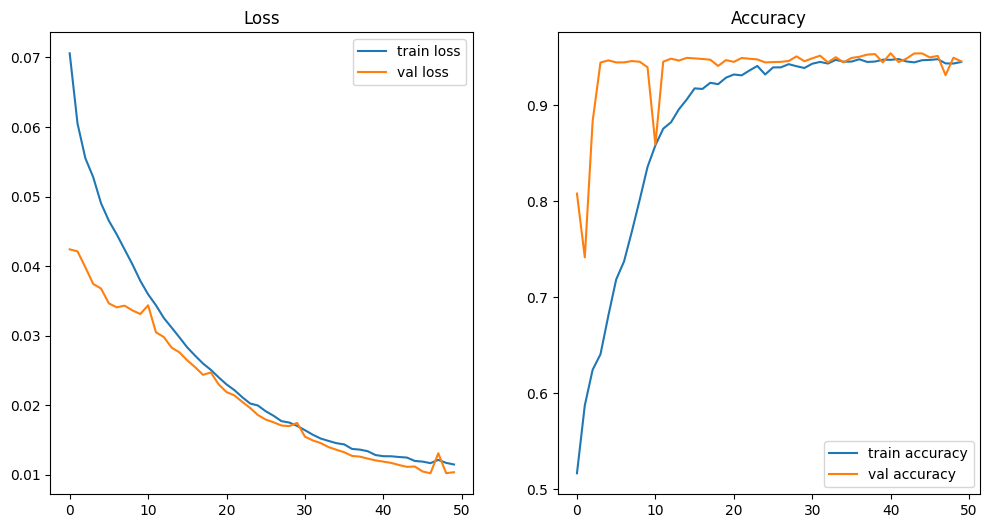

In [24]:
history = model.fit(
    fused_features_train, labels_train,
    epochs=50,
    batch_size=16,
    validation_data=(fused_features_val, labels_val),
    verbose=1
    # sample_weight=sample_weights
    # callbacks=[reduce_lr, early_stopping]
)

# 可视化训练曲线
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='train loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(history.history['accuracy'], label='train accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].legend()
axs[1].set_title('Accuracy')

plt.show()

In [25]:
results = model.evaluate(fused_features_test, labels_test)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"F1 Score: {results[2]:.4f}")  # F1Score 类的结果
print(f"Mean IoU: {results[3]:.4f}")  # MeanIoU 的结果

4/4 [==============================] - 0s 21ms/step - loss: 0.0120 - accuracy: 0.9418 - f1_score: 0.5024 - mean_io_u: 0.2500

Test Loss: 0.0120
Test Accuracy: 94.18%
F1 Score: 0.5024
Mean IoU: 0.2500


2024-08-14 13:36:37.854062: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-14 13:36:37.854122: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [41]:
# 保存模型
model.save_weights("custom_model_weights.h5")

4/4 [==============================] - 0s 16ms/step
Overall Classification Report:
              precision    recall  f1-score   support

    Non-slum       0.95      1.00      0.97    123154
        Slum       0.82      0.04      0.07      7406

    accuracy                           0.94    130560
   macro avg       0.88      0.52      0.52    130560
weighted avg       0.94      0.94      0.92    130560

Confusion Matrix
[[123094     60]
 [  7135    271]]


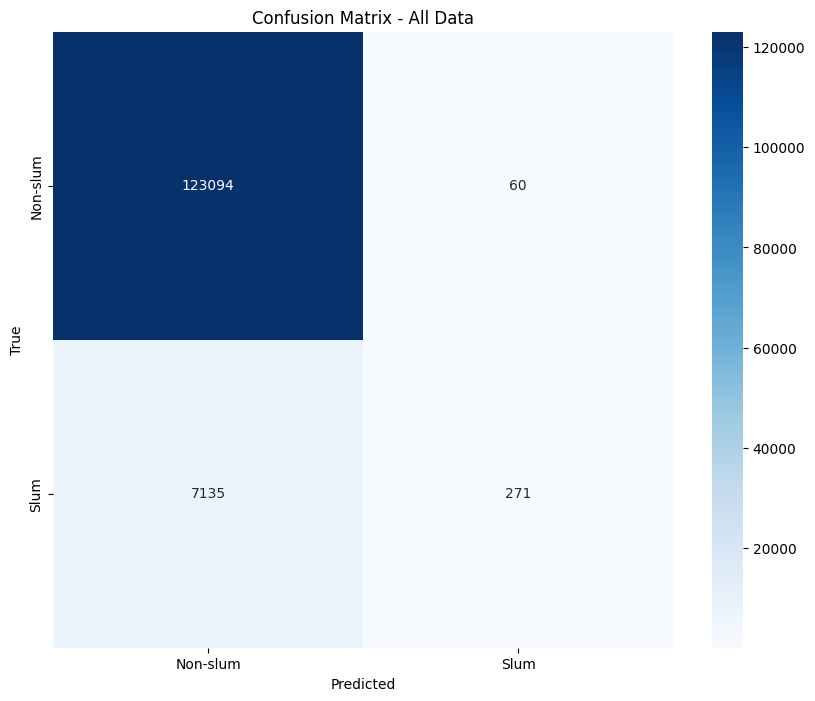

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 获取预测结果
train_predictions = model.predict(fused_features_train)
val_predictions = model.predict(fused_features_val)
test_predictions = model.predict(fused_features_test)

# 获取预测类别
train_pred_classes = np.argmax(train_predictions, axis=-1).flatten()
val_pred_classes = np.argmax(val_predictions, axis=-1).flatten()
test_pred_classes = np.argmax(test_predictions, axis=-1).flatten()

# 获取真实类别
train_true_classes = np.argmax(labels_train, axis=-1).flatten()
val_true_classes = np.argmax(labels_val, axis=-1).flatten()
test_true_classes = np.argmax(labels_test, axis=-1).flatten()

# 组合所有预测结果和真实标签
all_pred_classes = np.concatenate([train_pred_classes, val_pred_classes, test_pred_classes], axis=0)
all_true_classes = np.concatenate([train_true_classes, val_true_classes, test_true_classes], axis=0)

# 计算整体混淆矩阵
overall_cm = confusion_matrix(all_true_classes, all_pred_classes)

# 输出整体分类报告
class_labels = ['Non-slum', 'Slum']
overall_report = classification_report(all_true_classes, all_pred_classes, target_names=class_labels, zero_division=1)
print("Overall Classification Report:")
print(overall_report)

print("Confusion Matrix")
print(overall_cm)


# 可视化整体混淆矩阵
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - All Data')
    plt.show()


plot_confusion_matrix(overall_cm)

816/816 [==============================] - 2s 2ms/step
Overall Classification Report:
              precision    recall  f1-score   support

    Non-slum       0.97      0.98      0.98    123154
        Slum       0.65      0.51      0.57      7406

    accuracy                           0.96    130560
   macro avg       0.81      0.75      0.77    130560
weighted avg       0.95      0.96      0.95    130560

Confusion Matrix:
[[121105   2049]
 [  3638   3768]]


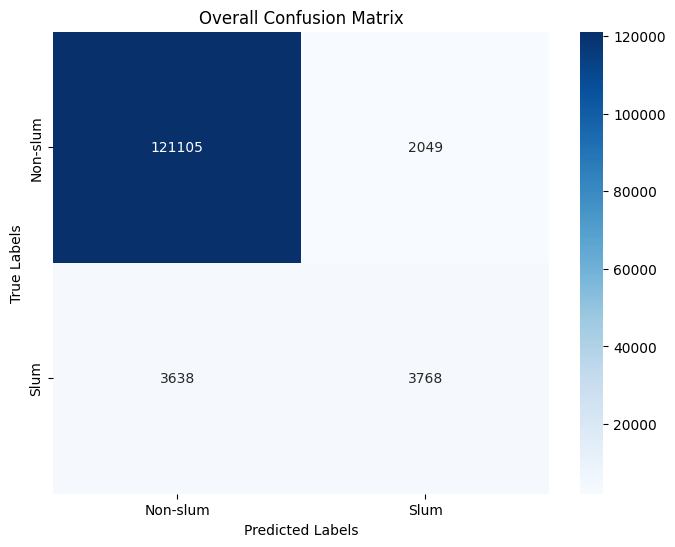

In [104]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 获取预测结果
train_predictions = model.predict(fused_features_train)
val_predictions = model.predict(fused_features_val)
test_predictions = model.predict(fused_features_test)

# 获取预测类别
train_pred_classes = np.argmax(train_predictions, axis=-1).flatten()
val_pred_classes = np.argmax(val_predictions, axis=-1).flatten()
test_pred_classes = np.argmax(test_predictions, axis=-1).flatten()

# 获取真实类别
train_true_classes = np.argmax(labels_train, axis=-1).flatten()
val_true_classes = np.argmax(labels_val, axis=-1).flatten()
test_true_classes = np.argmax(labels_test, axis=-1).flatten()

# 组合所有预测结果和真实标签
all_pred_classes = np.concatenate([train_pred_classes, val_pred_classes, test_pred_classes], axis=0)
all_true_classes = np.concatenate([train_true_classes, val_true_classes, test_true_classes], axis=0)

# 计算整体混淆矩阵
overall_cm = confusion_matrix(all_true_classes, all_pred_classes)

# 输出整体分类报告
class_labels = ['Non-slum', 'Slum']
overall_report = classification_report(all_true_classes, all_pred_classes, target_names=class_labels, zero_division=1)
print("Overall Classification Report:")
print(overall_report)

print("Confusion Matrix:")
print(overall_cm)


# 可视化整体混淆矩阵
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(overall_cm, title='Overall Confusion Matrix')

816/816 [==============================] - 2s 3ms/step
Training Predictions: (array([0, 1]), array([78329,     7]))
Validation Predictions: (array([0]), array([26112]))
Test Predictions: (array([0, 1]), array([26111,     1]))


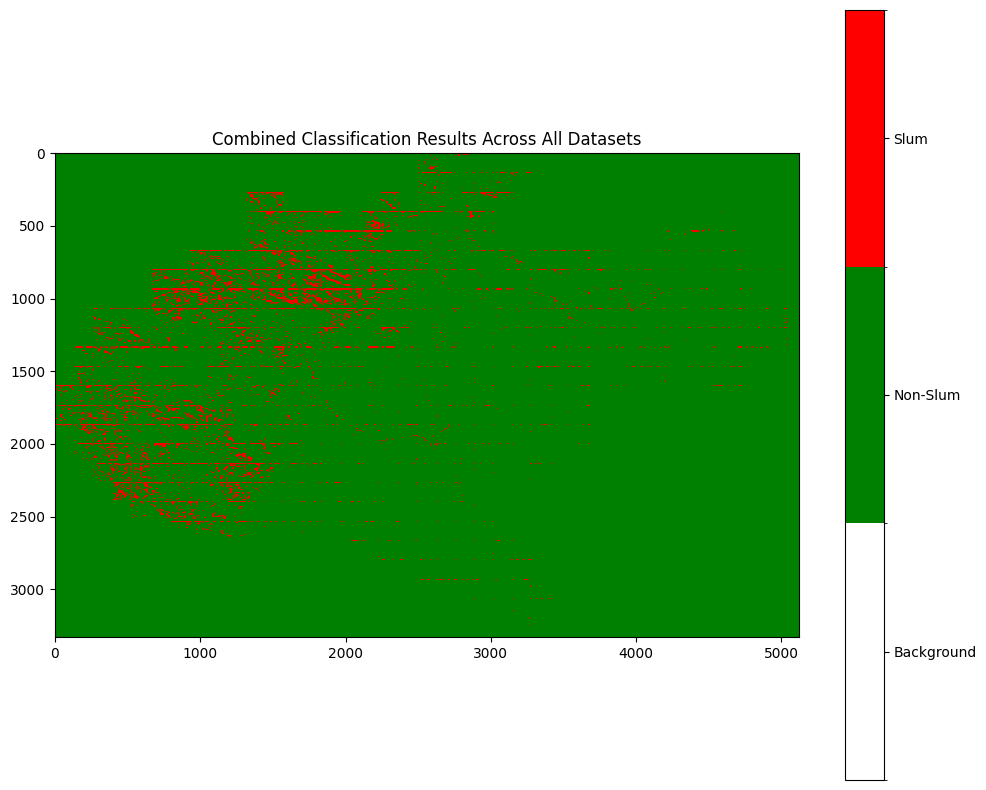

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf

# Define the dimensions and grid size for pixel bounds
original_height = 3201
original_width = 4993
PATCH_SIZE = 128
target_height = PATCH_SIZE * int(np.ceil(original_height / PATCH_SIZE))
target_width = PATCH_SIZE * int(np.ceil(original_width / PATCH_SIZE))
GRID_SIZE = 16

# Function to generate pixel bounds
def generate_pixel_bounds(patch_bounds, grid_size):
    pixel_bounds_list = []
    for bounds in patch_bounds:
        top_left, top_right, bottom_right, bottom_left = bounds
        width = (top_right[0] - top_left[0]) / grid_size
        height = (bottom_left[1] - top_left[1]) / grid_size
        for i in range(grid_size):
            for j in range(grid_size):
                pixel_top_left = (top_left[0] + j * width, top_left[1] + i * height)
                pixel_bounds_list.append([pixel_top_left, pixel_top_left, pixel_top_left, pixel_top_left])  # Simplified for visualization
    return pixel_bounds_list

# Function to reconstruct the image from pixel bounds
def reconstruct_image_from_pixel_bounds(pixel_predictions, pixel_bounds, original_shape):
    reconstructed_image = np.full(original_shape, fill_value=-1)
    for bounds, prediction in zip(pixel_bounds, pixel_predictions):
        start_i, start_j = int(bounds[0][1]), int(bounds[0][0])
        end_i, end_j = start_i + GRID_SIZE, start_j + GRID_SIZE
        if 0 <= start_i < original_shape[0] and 0 <= start_j < original_shape[1]:
            reconstructed_image[start_i:end_i, start_j:end_j] = prediction
    return reconstructed_image


# Load the pre-trained model
model = build_main_model((1, 1, pixel_feature_shape), 2)

# Predict on train, validation, and test sets
train_predictions = model.predict(fused_features_train)
val_predictions = model.predict(fused_features_val)
test_predictions = model.predict(fused_features_test)

# Get predicted classes
train_pred_classes = np.argmax(train_predictions, axis=-1)
val_pred_classes = np.argmax(val_predictions, axis=-1)
test_pred_classes = np.argmax(test_predictions, axis=-1)

# Print statistics
print("Training Predictions:", np.unique(train_pred_classes, return_counts=True))
print("Validation Predictions:", np.unique(val_pred_classes, return_counts=True))
print("Test Predictions:", np.unique(test_pred_classes, return_counts=True))

# Merge all bounds
train_bounds = get_mock_bounds()
val_bounds = get_mock_bounds()
test_bounds = get_mock_bounds()
all_bounds = np.concatenate([train_bounds, val_bounds, test_bounds])

# Generate pixel bounds
train_pixel_bounds = generate_pixel_bounds(train_bounds, GRID_SIZE)
val_pixel_bounds = generate_pixel_bounds(val_bounds, GRID_SIZE)
test_pixel_bounds = generate_pixel_bounds(test_bounds, GRID_SIZE)

# Convert and reconstruct images
train_reconstructed_image = reconstruct_image_from_pixel_bounds(train_pred_classes, train_pixel_bounds, (target_height, target_width))
val_reconstructed_image = reconstruct_image_from_pixel_bounds(val_pred_classes, val_pixel_bounds, (target_height, target_width))
test_reconstructed_image = reconstruct_image_from_pixel_bounds(test_pred_classes, test_pixel_bounds, (target_height, target_width))

# Merge reconstructed images
full_reconstructed_image = np.maximum.reduce([train_reconstructed_image, val_reconstructed_image, test_reconstructed_image])

cmap = mcolors.ListedColormap(['white', 'green', 'red'])  # 背景, Non-slum, Slum
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualize combined classification results
plt.figure(figsize=(12, 10))
img = plt.imshow(reconstructed_image, cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=[-1, 0, 1], spacing='proportional')
cbar.ax.set_yticklabels(['Background', 'Non-Slum', 'Slum'])  # 更新颜色条的标签
plt.title('Combined Classification Results Across All Datasets')
plt.show()

816/816 [==============================] - 2s 3ms/step
Training Predictions: (array([0, 1]), array([62946, 15390]))
Validation Predictions: (array([0, 1]), array([21036,  5076]))
Test Predictions: (array([0, 1]), array([21704,  4408]))
Geo bounds: (4081450.0, -161210.0, 4131370.0, -129210.0)
Number of train pixel bounds: 78336
Number of val pixel bounds: 26112
Number of test pixel bounds: 26112
Example of train_pixel_bounds: [[(1050, 931), (1058, 931), (1058, 939), (1050, 939)], [(1058, 931), (1066, 931), (1066, 939), (1058, 939)], [(1066, 931), (1074, 931), (1074, 939), (1066, 939)], [(1074, 931), (1082, 931), (1082, 939), (1074, 939)], [(1082, 931), (1091, 931), (1091, 939), (1082, 939)]]
Example of val_pixel_bounds: [[(1575, 665), (1583, 665), (1583, 673), (1575, 673)], [(1583, 665), (1591, 665), (1591, 673), (1583, 673)], [(1591, 665), (1599, 665), (1599, 673), (1591, 673)], [(1599, 665), (1607, 665), (1607, 673), (1599, 673)], [(1607, 665), (1616, 665), (1616, 673), (1607, 673)]]


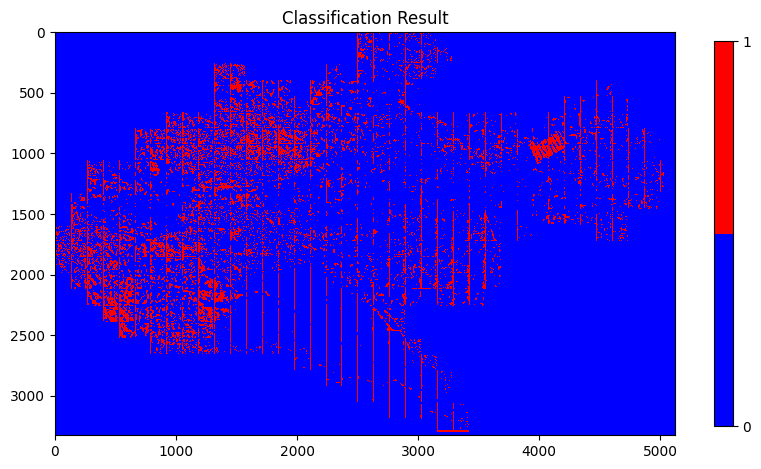

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf

# 原始图像尺寸
original_height = 3201
original_width = 4993

# 计算填充后的图像尺寸
PATCH_SIZE = 128
target_height = PATCH_SIZE * int(np.ceil(original_height / PATCH_SIZE))
target_width = PATCH_SIZE * int(np.ceil(original_width / PATCH_SIZE))


# 使用你提供的生成 pixel 边界的函数
def generate_pixel_bounds(patch_bounds, grid_size):
    pixel_bounds_list = []
    for bounds in patch_bounds:
        top_left, top_right, bottom_right, bottom_left = bounds
        width = (top_right[0] - top_left[0]) / grid_size
        height = (bottom_left[1] - top_left[1]) / grid_size
        for i in range(grid_size):
            for j in range(grid_size):
                pixel_top_left = (top_left[0] + j * width, top_left[1] + i * height)
                pixel_top_right = (top_left[0] + (j + 1) * width, top_left[1] + i * height)
                pixel_bottom_left = (top_left[0] + j * width, top_left[1] + (i + 1) * height)
                pixel_bottom_right = (top_left[0] + (j + 1) * width, top_left[1] + (i + 1) * height)
                pixel_bounds_list.append([pixel_top_left, pixel_top_right, pixel_bottom_right, pixel_bottom_left])
    return pixel_bounds_list


# 将地理坐标转换为像素坐标
def geo_to_pixel(geo_coord, geo_bounds, img_shape):
    min_x, min_y, max_x, max_y = geo_bounds
    x, y = geo_coord
    pixel_x = int((x - min_x) / (max_x - min_x) * (img_shape[1] - 1))
    pixel_y = int((max_y - y) / (max_y - min_y) * (img_shape[0] - 1))  # 修改为 (max_y - y) 来反转 y 坐标
    return (pixel_x, pixel_y)

def convert_bounds_to_pixel(bounds, geo_bounds, img_shape):
    return [geo_to_pixel(coord, geo_bounds, img_shape) for coord in bounds]

# 从 patch_bounds 中提取 geo_bounds
def get_geo_bounds(patch_bounds):
    min_x = min([coord[0] for bounds in patch_bounds for coord in bounds])
    min_y = min([coord[1] for bounds in patch_bounds for coord in bounds])
    max_x = max([coord[0] for bounds in patch_bounds for coord in bounds])
    max_y = max([coord[1] for bounds in patch_bounds for coord in bounds])
    return (min_x, min_y, max_x, max_y)


# 加载预训练的模型
model = build_main_model((1, 1, pixel_feature_shape), 2)

# 对训练集、验证集和测试集进行预测
train_predictions = model.predict(fused_features_train)
val_predictions = model.predict(fused_features_val)
test_predictions = model.predict(fused_features_test)

# 选择每个像素的类别
train_pred_labels = np.argmax(train_predictions, axis=-1).flatten()
val_pred_labels = np.argmax(val_predictions, axis=-1).flatten()
test_pred_labels = np.argmax(test_predictions, axis=-1).flatten()

# 打印预测结果的统计信息
print("Training Predictions:", np.unique(train_pred_labels, return_counts=True))
print("Validation Predictions:", np.unique(val_pred_labels, return_counts=True))
print("Test Predictions:", np.unique(test_pred_labels, return_counts=True))

# 合并所有的 patch 边界
all_bounds = np.concatenate([train_bounds, val_bounds, test_bounds])

# 获取 geo_bounds
geo_bounds = get_geo_bounds(all_bounds)
print("Geo bounds:", geo_bounds)

# 生成像素网格
GRID_SIZE = 16
train_pixel_bounds = generate_pixel_bounds(train_bounds, GRID_SIZE)
val_pixel_bounds = generate_pixel_bounds(val_bounds, GRID_SIZE)
test_pixel_bounds = generate_pixel_bounds(test_bounds, GRID_SIZE)

# 确认生成的像素边界数量是否正确
print(f"Number of train pixel bounds: {len(train_pixel_bounds)}")
print(f"Number of val pixel bounds: {len(val_pixel_bounds)}")
print(f"Number of test pixel bounds: {len(test_pixel_bounds)}")

# 将 geo_bounds 转换为像素坐标
train_pixel_bounds = [convert_bounds_to_pixel(bounds, geo_bounds, (target_height, target_width)) for bounds in train_pixel_bounds]
val_pixel_bounds = [convert_bounds_to_pixel(bounds, geo_bounds, (target_height, target_width)) for bounds in val_pixel_bounds]
test_pixel_bounds = [convert_bounds_to_pixel(bounds, geo_bounds, (target_height, target_width)) for bounds in test_pixel_bounds]

# 打印一些 pixel_bounds 以进行验证
print(f"Example of train_pixel_bounds: {train_pixel_bounds[:5]}")
print(f"Example of val_pixel_bounds: {val_pixel_bounds[:5]}")
print(f"Example of test_pixel_bounds: {test_pixel_bounds[:5]}")

# 重构图像
def reconstruct_image_from_pixel_bounds(pixel_predictions, pixel_bounds, original_shape):
    reconstructed_image = np.full(original_shape, fill_value=-1)
    for bounds, prediction in zip(pixel_bounds, pixel_predictions):
        top_left, top_right, bottom_right, bottom_left = bounds
        start_i, start_j = int(top_left[1]), int(top_left[0])
        end_i, end_j = int(bottom_right[1]), int(bottom_right[0])
        
        # 打印调试信息
        # print(f"Bounds: {bounds}, Prediction: {prediction}")
        
        # 检查是否在图像范围内
        if 0 <= start_i < original_shape[0] and 0 <= start_j < original_shape[1]:
            end_i = min(end_i, original_shape[0])
            end_j = min(end_j, original_shape[1])
            reconstructed_image[start_i:end_i, start_j:end_j] = prediction
        else:
            print(f"Skipping invalid grid: {start_i, start_j, end_i, end_j}")
    return reconstructed_image


# 重构训练集、验证集和测试集的预测结果
reconstructed_train_image = reconstruct_image_from_pixel_bounds(
    train_pred_labels, train_pixel_bounds, (target_height, target_width)
)
reconstructed_val_image = reconstruct_image_from_pixel_bounds(
    val_pred_labels, val_pixel_bounds, (target_height, target_width)
)
reconstructed_test_image = reconstruct_image_from_pixel_bounds(
    test_pred_labels, test_pixel_bounds, (target_height, target_width)
)

# 打印重构图像的统计信息
print(f"Unique values in reconstructed_train_image: {np.unique(reconstructed_train_image)}")
print(f"Unique values in reconstructed_val_image: {np.unique(reconstructed_val_image)}")
print(f"Unique values in reconstructed_test_image: {np.unique(reconstructed_test_image)}")

# 合并重构的结果
reconstructed_image = np.zeros_like(reconstructed_train_image)
reconstructed_image[reconstructed_train_image != -1] = reconstructed_train_image[reconstructed_train_image != -1]
reconstructed_image[reconstructed_val_image != -1] = reconstructed_val_image[reconstructed_val_image != -1]
reconstructed_image[reconstructed_test_image != -1] = reconstructed_test_image[reconstructed_test_image != -1]

# 打印最终重构图像的统计信息
print(f"Unique values in reconstructed_image: {np.unique(reconstructed_image)}")

# 定义类别颜色
colors = ['blue', 'red']
cmap = mcolors.ListedColormap(colors)

# 可视化重构的分类结果
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_image, cmap=cmap)
plt.title('Classification Result')
plt.colorbar(ticks=range(len(colors)), shrink=0.5)
plt.show()

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf

# 原始图像尺寸
original_height = 3201
original_width = 4993

# 计算填充后的图像尺寸
PATCH_SIZE = 128
target_height = PATCH_SIZE * int(np.ceil(original_height / PATCH_SIZE))
target_width = PATCH_SIZE * int(np.ceil(original_width / PATCH_SIZE))

# 使用你提供的生成 pixel 边界的函数
def generate_pixel_bounds(patch_bounds, grid_size):
    pixel_bounds_list = []
    for bounds in patch_bounds:
        top_left, top_right, bottom_right, bottom_left = bounds
        width = (top_right[0] - top_left[0]) / grid_size
        height = (bottom_left[1] - top_left[1]) / grid_size
        for i in range(grid_size):
            for j in range(grid_size):
                pixel_top_left = (top_left[0] + j * width, top_left[1] + i * height)
                pixel_top_right = (top_left[0] + (j + 1) * width, top_left[1] + i * height)
                pixel_bottom_left = (top_left[0] + j * width, top_left[1] + (i + 1) * height)
                pixel_bottom_right = (top_left[0] + (j + 1) * width, top_left[1] + (i + 1) * height)
                pixel_bounds_list.append([pixel_top_left, pixel_top_right, pixel_bottom_right, pixel_bottom_left])
    return pixel_bounds_list

# 将地理坐标转换为像素坐标
def geo_to_pixel(geo_coord, geo_bounds, img_shape):
    min_x, min_y, max_x, max_y = geo_bounds
    x, y = geo_coord
    pixel_x = int((x - min_x) / (max_x - min_x) * (img_shape[1] - 1))
    pixel_y = int((max_y - y) / (max_y - min_y) * (img_shape[0] - 1))  # 修改为 (max_y - y) 来反转 y 坐标
    return (pixel_x, pixel_y)

def convert_bounds_to_pixel(bounds, geo_bounds, img_shape):
    return [geo_to_pixel(coord, geo_bounds, img_shape) for coord in bounds]

# 从 patch_bounds 中提取 geo_bounds
def get_geo_bounds(patch_bounds):
    min_x = min([coord[0] for bounds in patch_bounds for coord in bounds])
    min_y = min([coord[1] for bounds in patch_bounds for coord in bounds])
    max_x = max([coord[0] for bounds in patch_bounds for coord in bounds])
    max_y = max([coord[1] for bounds in patch_bounds for coord in bounds])
    return (min_x, min_y, max_x, max_y)

# 加载预训练的模型
model = build_main_model((1, 1, pixel_feature_shape), 3)

# 对训练集、验证集和测试集进行预测
train_predictions = model.predict(fused_features_train)
val_predictions = model.predict(fused_features_val)
test_predictions = model.predict(fused_features_test)

# # 选择每个像素的类别
# train_pred_labels = np.argmax(train_predictions, axis=-1).flatten()
# val_pred_labels = np.argmax(val_predictions, axis=-1).flatten()
# test_pred_labels = np.argmax(test_predictions, axis=-1).flatten()

# 打印预测结果的统计信息
print("Training Predictions:", np.unique(train_pred_labels, return_counts=True))
print("Validation Predictions:", np.unique(val_pred_labels, return_counts=True))
print("Test Predictions:", np.unique(test_pred_labels, return_counts=True))

# 自定义逻辑：如果非正规住区的概率大于50%，则该pixel为非正规住区，否则为正规住区
def custom_classification(predictions, mask):
    informal_prob = predictions[:, :, :, 2]  # 非正规住区类别的概率
    custom_class_predictions = np.where(informal_prob > 0.5, 2, 1)  # 非正规住区 (2) 和正规住区 (1)
    custom_class_predictions[mask == 0] = 0  # 研究区范围外
    return custom_class_predictions.flatten()



train_mask = mask_train # 根据您的数据定义
val_mask = mask_val    # 根据您的数据定义
test_mask = mask_test   # 根据您的数据定义

train_pred_labels = custom_classification(train_predictions, train_mask)
val_pred_labels = custom_classification(val_predictions, val_mask)
test_pred_labels = custom_classification(test_predictions, test_mask)

# 打印预测结果的统计信息
print("Training Predictions:", np.unique(train_pred_labels, return_counts=True))
print("Validation Predictions:", np.unique(val_pred_labels, return_counts=True))
print("Test Predictions:", np.unique(test_pred_labels, return_counts=True))

# 合并所有的 patch 边界
all_bounds = np.concatenate([train_bounds, val_bounds, test_bounds])

# 获取 geo_bounds
geo_bounds = get_geo_bounds(all_bounds)
print("Geo bounds:", geo_bounds)

# 生成像素网格
GRID_SIZE = 16
train_pixel_bounds = generate_pixel_bounds(train_bounds, GRID_SIZE)
val_pixel_bounds = generate_pixel_bounds(val_bounds, GRID_SIZE)
test_pixel_bounds = generate_pixel_bounds(test_bounds, GRID_SIZE)

# 确认生成的像素边界数量是否正确
print(f"Number of train pixel bounds: {len(train_pixel_bounds)}")
print(f"Number of val pixel bounds: {len(val_pixel_bounds)}")
print(f"Number of test pixel bounds: {len(test_pixel_bounds)}")

# 将 geo_bounds 转换为像素坐标
train_pixel_bounds = [convert_bounds_to_pixel(bounds, geo_bounds, (target_height, target_width)) for bounds in train_pixel_bounds]
val_pixel_bounds = [convert_bounds_to_pixel(bounds, geo_bounds, (target_height, target_width)) for bounds in val_pixel_bounds]
test_pixel_bounds = [convert_bounds_to_pixel(bounds, geo_bounds, (target_height, target_width)) for bounds in test_pixel_bounds]

# 打印一些 pixel_bounds 以进行验证
print(f"Example of train_pixel_bounds: {train_pixel_bounds[:5]}")
print(f"Example of val_pixel_bounds: {val_pixel_bounds[:5]}")
print(f"Example of test_pixel_bounds: {test_pixel_bounds[:5]}")

# 重构图像
def reconstruct_image_from_pixel_bounds(pixel_predictions, pixel_bounds, original_shape):
    reconstructed_image = np.full(original_shape, fill_value=-1)
    for bounds, prediction in zip(pixel_bounds, pixel_predictions):
        top_left, top_right, bottom_right, bottom_left = bounds
        start_i, start_j = int(top_left[1]), int(top_left[0])
        end_i, end_j = int(bottom_right[1]), int(bottom_right[0])
        
        # 打印调试信息
        # print(f"Bounds: {bounds}, Prediction: {prediction}")
        
        # 检查是否在图像范围内
        if 0 <= start_i < original_shape[0] and 0 <= start_j < original_shape[1]:
            end_i = min(end_i, original_shape[0])
            end_j = min(end_j, original_shape[1])
            reconstructed_image[start_i:end_i, start_j:end_j] = prediction
        else:
            print(f"Skipping invalid grid: {start_i, start_j, end_i, end_j}")
    return reconstructed_image

# 重构训练集、验证集和测试集的预测结果
reconstructed_train_image = reconstruct_image_from_pixel_bounds(
    train_pred_labels, train_pixel_bounds, (target_height, target_width)
)
reconstructed_val_image = reconstruct_image_from_pixel_bounds(
    val_pred_labels, val_pixel_bounds, (target_height, target_width)
)
reconstructed_test_image = reconstruct_image_from_pixel_bounds(
    test_pred_labels, test_pixel_bounds, (target_height, target_width)
)

# 打印重构图像的统计信息
print(f"Unique values in reconstructed_train_image: {np.unique(reconstructed_train_image)}")
print(f"Unique values in reconstructed_val_image: {np.unique(reconstructed_val_image)}")
print(f"Unique values in reconstructed_test_image: {np.unique(reconstructed_test_image)}")

# 合并重构的结果
reconstructed_image = np.zeros_like(reconstructed_train_image)
reconstructed_image[reconstructed_train_image != -1] = reconstructed_train_image[reconstructed_train_image != -1]
reconstructed_image[reconstructed_val_image != -1] = reconstructed_val_image[reconstructed_val_image != -1]
reconstructed_image[reconstructed_test_image != -1] = reconstructed_test_image[reconstructed_test_image != -1]

# 打印最终重构图像的统计信息
print(f"Unique values in reconstructed_image: {np.unique(reconstructed_image)}")

# 定义类别颜色
colors = ['black', 'blue', 'red']  # 0: 研究区外, 1: 正规住区, 2: 非正规住区
cmap = mcolors.ListedColormap(colors)

# 可视化重构的分类结果
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_image, cmap=cmap)
plt.title('Classification Result')
plt.colorbar(ticks=range(len(colors)), shrink=0.5)
plt.show()

816/816 [==============================] - 5s 6ms/step
Training Predictions: (array([1]), array([78336]))
Validation Predictions: (array([1]), array([26112]))
Test Predictions: (array([1]), array([26112]))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 78336 but corresponding boolean dimension is 306